In [1]:
#importing Useful DataStructures
import pandas as pd
import numpy as np
from scipy.stats import uniform

#importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# from prettytable import PrettyTable

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
# Import XGBClassifier từ thư viện XGBoost
from xgboost import XGBClassifier
from xgboost import XGBRegressor

# Import LGBMClassifier từ thư viện LightGBM
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

In [3]:
# Đường dẫn tới file .pkl
data_path = '/kaggle/input/data-final/train_data_final.pkl'
test_path = '/kaggle/input/data-final/test_data_final.pkl'
# Mở file .pkl và đọc dữ liệu
with open(data_path, 'rb') as file:
    data = pickle.load(file)

with open(test_path, 'rb') as file:
    test = pickle.load(file)

In [4]:
data.drop(labels="Unnamed: 0",axis=1,inplace=True)
test.drop(labels="Unnamed: 0",axis=1,inplace=True)

In [5]:
y = data[["TARGET"]]
X = data.drop(columns=["TARGET"])
# Tạm thời del data và test để tối ưu RAM
del data

In [6]:
empty_columns = []
for col in X.columns:
    if len(X[col].unique()) <=1:
        empty_columns.append(col)
    
print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
X = X.drop(empty_columns, axis = 1)
test = test.drop(empty_columns, axis = 1)

There are 23 columns with just 1 unique value
Removing these from dataset


In [8]:
#removing the SK_ID_CURR from training and test data
X = X.drop(['SK_ID_CURR'], axis = 1)
skid_test = test.pop('SK_ID_CURR')

In [9]:
#standardizing the data
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# test = scaler.fit_transform(test)
#replacing nan values with 0
X[np.isnan(X)] = 0
test[np.isnan(test)] = 0

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score

In [11]:
class modelling:
    '''
    Class for Doing Hyperparameter tuning to find best set of hyperparameters, building models on best hyperparams and
    displaying results on best hyperparameters.
    
    It has 4 methods:
        1. init method
        2. random_search_cv method
        3. train_on_best_params method
        4. proba_to_class method
        5. tune_threshold method
        6. results_on_best_params method
        7. feat_importances_show method
    '''
    def __init__(self, base_model, x_train, y_train, x_test, calibration = False, calibration_method = 'isotonic',
                 calibration_cv = 4, k_folds = 4, random_state = 42):
        '''
        Function to initialize the class members.
        
        Inputs: 
            self
            base_model: estimator/classifier
                The base model to be used for the modelling purpose
            x_train: numpy array
                Training standardized data
            y_train: numpy array
                Training class labels
            x_test: numpy array
                Test standardized data
            calibration: bool, default = False
                Whether to calibrate the model for generating class probabilities
            calibration_method: str, default = 'isotonic'
                The type of calibration to use, i.e. sigmoid or isotonic
            calibration_cv: int, default = 4
                Number of cross-validation folds for calibrating the probabilities
            k_folds: int, default = 4
                Number of cross-validation folds for training and tuning the model
            random_state: int, default = 42
                Random state for StratifiedKFold for reproducibility
                
        Returns: 
            None            
        '''
        self.base_model = base_model
        self.num_folds = k_folds
        self.kfolds = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = random_state)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.calibration = calibration
        if self.calibration:
            self.calibration_method = calibration_method
            self.calibration_cv = calibration_cv

    def random_search_cv(self, hyperparams_dict, n_iter = 30, verbose = True, n_jobs = 1, random_state = 42):
        '''
        Function to do RandomizedSearchCV on training data.
        
        Inputs:
            self
            hyperparams_dict: dict
                Dictionary of hyperparameters to tune
            n_iter: int, default = 30
                Number of iterations to perform for random search
            verbose: bool, default = True
                Whether to keep verbosity or not
            n_jobs: int, default = 1
                Number of cores to use for Random Search
            random_state: int, default = 42
                Random state for reproducibility of RandomizedSearchCV
                
        Returns:
            None
        '''
        
        if verbose:
            start = datetime.now()
            print(f"Doing Randomized Search CV on Classifier with {n_iter} random initializations...")
        rscv = RandomizedSearchCV(self.base_model, hyperparams_dict, n_iter = n_iter, scoring = 'roc_auc', 
                                  cv = self.kfolds, return_train_score = True, verbose = 2,
                                  n_jobs = n_jobs, random_state = random_state)
        rscv.fit(self.x_train, self.y_train)
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        
        #getting the Search Results
        self.tuning_results = pd.DataFrame(rscv.cv_results_)
        #best model
        self.best_model = rscv.best_estimator_
        
        gc.collect()


    def grid_search_cv(self, hyperparams_dict, verbose=True, n_jobs=1):
        '''
        Function to do GridSearchCV on training data.
        
        Inputs:
            self
            hyperparams_dict: dict
                Dictionary of hyperparameters to tune
            verbose: bool, default = True
                Whether to keep verbosity or not
            n_jobs: int, default = 1
                Number of cores to use for Grid Search
            
        Returns:
            None
        '''
        
        if verbose:
            start = datetime.now()
            print("Performing Grid Search CV on Classifier...")
        
        gscv = GridSearchCV(self.base_model, hyperparams_dict, scoring='roc_auc', 
                            cv=self.kfolds, return_train_score=True, 
                            verbose=2, n_jobs=n_jobs)
    
        gscv.fit(self.x_train, self.y_train)
    
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        
        # Getting the Search Results
        self.tuning_results = pd.DataFrame(gscv.cv_results_)
        # Best model
        self.best_model = gscv.best_estimator_
        
        gc.collect()

    
    def train_on_best_params(self, verbose = True):
        '''
        Function to train the model on best hyperparameters obtained from previous method.
        Generates Cross-Validation predictions as Out-of-fold predictions
        
        Inputs:
            self
            verbose: bool, default = True
                Whether to keep verbosity or not
        
        Returns:
            None
        '''
        
        if verbose:
            print("Fitting Classifier on best parameters\n")
            print(f"{self.num_folds}-Fold Cross Validation")
            start = datetime.now()
            
        self.cv_preds_probas = np.zeros(self.x_train.shape[0])
        #we will select a best threshold for each fold of cross-validation and average over the
        #folds to find the optimal threshold
        self.best_threshold_train = 0
        for fold_number, (train_indices, val_indices) in enumerate(self.kfolds.split(self.x_train, self.y_train), 1):
            if verbose:
                print(f"\tFitting Fold {fold_number}")
                
            self.best_model.fit(self.x_train.iloc[train_indices], self.y_train.iloc[train_indices])
            if not self.calibration:
                self.train_preds_probas = self.best_model.predict_proba(self.x_train.iloc[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.best_model.predict_proba(self.x_train.iloc[val_indices])[:,1]
            else:
                #fitting the calibration Classifier over the base model for calibrated probabilities
                self.calibrated_classifier = CalibratedClassifierCV(self.best_model, method = self.calibration_method, cv = self.calibration_cv)
                self.calibrated_classifier.fit(self.x_train.iloc[train_indices], self.y_train.iloc[train_indices])
                
                self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train.iloc[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.calibrated_classifier.predict_proba(self.x_train.iloc[val_indices])[:,1]
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train.iloc[train_indices], self.train_preds_probas) / self.num_folds
        
        #converting the class probabilities to class labels
        self.cv_preds_class = self.proba_to_class(self.cv_preds_probas, self.best_threshold_train)
        
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
            
        gc.collect()
    
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''
        return np.where(proba >= threshold, 1, 0)

    # def tune_threshold(self, true_labels, predicted_probas):
    #     '''
    #     Function to find the optimal threshold for minimizing False Negatives (maximize Recall/TPR).
        
    #     Inputs:
    #         self
    #         true_labels: numpy array or pandas series
    #             True Class Labels
    #         predicted_probas: numpy array
    #             Predicted Probabilities for the Positive Class
                    
    #     Returns:
    #         Optimal threshold probability
    #     '''
    #     # Calculate the ROC curve
    #     fpr, tpr, thresholds = roc_curve(true_labels, predicted_probas)
        
    #     # To minimize false negatives, maximize recall (TPR)
    #     # Find the threshold corresponding to the maximum TPR
    #     optimal_index = np.argmax(tpr)  # Find the index of the highest TPR
    #     optimal_threshold = thresholds[optimal_index]
    
    #     print(f"Optimal Threshold (to minimize false negatives): {optimal_threshold}")
    #     return optimal_threshold

    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''
        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
        
    def results_on_best_params(self, model_name):
        '''
        Function to train the whole data on best parameters and display the results.
        
        Inputs:
            self
            model_name: str
                model name to get feature importances.
        
        Returns:
            None
        '''
        #we have to fit the whole model for optimal test predictions
        self.best_model.fit(self.x_train, self.y_train)
        if not self.calibration:
            self.train_preds_probas = self.best_model.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.best_model.predict_proba(self.x_test)[:,1]
        else:
            #fitting calibration model over whole training data for test predictions
            self.calibrated_classifier.fit(self.x_train, self.y_train)
            self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.calibrated_classifier.predict_proba(self.x_test)[:,1]
        
        #getting class labels from probabilities
        self.train_preds_class = self.proba_to_class(self.train_preds_probas, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_probas, self.best_threshold_train)
        
        #feature importances
        if model_name == 'linear':
            self.feat_imp = self.best_model.coef_[0]
        else:
            self.feat_imp = self.best_model.feature_importances_
                
        print("=" * 100)
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        print("Train Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        print('=' * 100)
        print("Confusion Matrix of CV data:")
        conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
        conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
        plt.figure(figsize = (7,6))
        plt.title('Confusion Matrix Heatmap')
        sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
        plt.show()
        
        gc.collect()
        
    def feat_importances_show(self, feature_names, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            feature_names: numpy array
                Names of features of training set
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        #getting the top features indices and their names
        top_feats_indices = np.argsort(self.feat_imp)[::-1][:num_features]
        feat_importance_top = self.feat_imp[top_feats_indices]
        column_names = feature_names[top_feats_indices]
        
        #plotting a horizontal bar plot of feature importances
        plt.figure(figsize = figsize) 
        sns.barplot(feat_importance_top, list(range(num_features)), orient = 'h')
        plt.yticks(list(range(50)), column_names)
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

In [12]:
decision_tree = DecisionTreeClassifier(max_depth=7,criterion="entropy",class_weight="balanced",random_state=42)

model = modelling(base_model=decision_tree, 
                  x_train=X, 
                  y_train=y, 
                  x_test=test,calibration=False)

In [13]:
# Từ điển siêu tham số cho Decision Tree
# hyperparams_dict = {
#     'max_depth': [9, 15, 20, 25, None],
#     'min_samples_split': [2, 5, 10, 20, None],
#     'min_samples_leaf': [1, 2, 5, 10, None],
#     # 'max_features':['auto','sqrt','log2']
# }

hyperparams_dict = {
    # "max_depth": [5, 7, 15, 20, 30],
    "min_samples_split": [10, 20, 30, 50],
    "min_samples_leaf": [15, 25, 35, 50]
}
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
,
# Tuning siêu tham số với RandomizedSearchCV
# model.grid_search_cv(hyperparams_dict, verbose=True, n_jobs=1)
model.random_search_cv(hyperparams_dict=hyperparams_dict, n_iter=30, n_jobs=1)

Doing Randomized Search CV on Classifier with 30 random initializations...
Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END ..........min_samples_leaf=15, min_samples_split=10; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_split=10; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_split=10; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_split=10; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_split=20; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_split=20; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_split=20; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_split=20; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_split=30; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_split=30; total time= 2.2min
[CV] END ..........min_samples_leaf=15, min_samples_sp

In [14]:
turning_res = model.tuning_results
turning_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,132.576847,0.885735,0.488689,0.006199,10,15,"{'min_samples_split': 10, 'min_samples_leaf': 15}",0.748017,0.755842,0.753158,0.752018,0.752259,0.002815,9,0.772514,0.769792,0.770200,0.770611,0.770779,0.001043
1,133.063214,0.460752,0.504319,0.019282,20,15,"{'min_samples_split': 20, 'min_samples_leaf': 15}",0.748017,0.755842,0.753158,0.752018,0.752259,0.002815,9,0.772514,0.769792,0.770200,0.770611,0.770779,0.001043
2,133.114480,0.550937,0.495671,0.012586,30,15,"{'min_samples_split': 30, 'min_samples_leaf': 15}",0.748017,0.755842,0.753158,0.752018,0.752259,0.002815,9,0.772514,0.769792,0.770200,0.770611,0.770779,0.001043
3,132.741091,0.648875,0.495069,0.016110,50,15,"{'min_samples_split': 50, 'min_samples_leaf': 15}",0.748101,0.755842,0.753158,0.751831,0.752233,0.002789,16,0.772498,0.769792,0.770200,0.770450,0.770735,0.001045
4,132.922090,0.941208,0.490392,0.005652,10,25,"{'min_samples_split': 10, 'min_samples_leaf': 25}",0.748992,0.756200,0.753029,0.750740,0.752240,0.002698,12,0.772531,0.769670,0.770121,0.770439,0.770691,0.001097
5,134.135821,1.163734,0.506568,0.013258,20,25,"{'min_samples_split': 20, 'min_samples_leaf': 25}",0.748992,0.756200,0.753029,0.750740,0.752240,0.002698,12,0.772531,0.769670,0.770121,0.770439,0.770691,0.001097
6,132.615926,0.360656,0.520158,0.046178,30,25,"{'min_samples_split': 30, 'min_samples_leaf': 25}",0.748992,0.756200,0.753029,0.750740,0.752240,0.002698,12,0.772531,0.769670,0.770121,0.770439,0.770691,0.001097
7,131.926074,0.345220,0.532831,0.056590,50,25,"{'min_samples_split': 50, 'min_samples_leaf': 25}",0.748992,0.756200,0.753029,0.750740,0.752240,0.002698,12,0.772531,0.769670,0.770121,0.770439,0.770691,0.001097
8,132.559230,0.237550,0.486568,0.002741,10,35,"{'min_samples_split': 10, 'min_samples_leaf': 35}",0.749450,0.756535,0.754897,0.750678,0.752890,0.002917,5,0.772375,0.769494,0.770040,0.770483,0.770598,0.001084
9,132.971254,0.527649,0.490235,0.007197,20,35,"{'min_samples_split': 20, 'min_samples_leaf': 35}",0.749450,0.756535,0.754897,0.750678,0.752890,0.002917,5,0.772375,0.769494,0.770040,0.770483,0.770598,0.001084


Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:08:54.389180

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.5210105650562783

Train Results:
	ROC-AUC Score = 0.7681326665292977
	Precision Score = 0.1868104089219331
	Recall Score = 0.6320688267256993
CV Results:
	ROC-AUC Score = 0.7531399641737558
	Precision Score = 0.16659559524406764
	Recall Score = 0.668293419199034
Confusion Matrix of CV data:


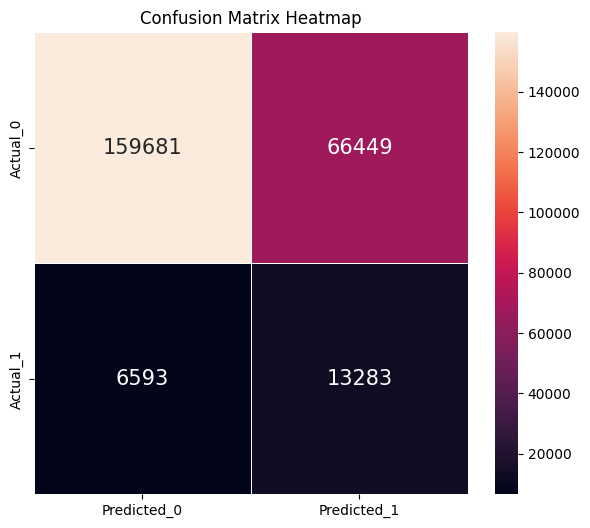

In [15]:
# Huấn luyện mô hình với bộ siêu tham số tối ưu
model.train_on_best_params()
# Hiển thị kết quả của mô hình
model.results_on_best_params(model_name='tree')

In [16]:
turning_res[turning_res["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,132.649178,1.335087,0.520314,0.057095,10,50,"{'min_samples_split': 10, 'min_samples_leaf': 50}",0.749961,0.756909,0.755331,0.750905,0.753277,0.002917,1,0.771966,0.769311,0.769646,0.770569,0.770373,0.001029
13,132.089650,0.546949,0.495170,0.015660,20,50,"{'min_samples_split': 20, 'min_samples_leaf': 50}",0.749961,0.756909,0.755331,0.750905,0.753277,0.002917,1,0.771966,0.769311,0.769646,0.770569,0.770373,0.001029
14,133.080460,1.215974,0.525505,0.048704,30,50,"{'min_samples_split': 30, 'min_samples_leaf': 50}",0.749961,0.756909,0.755331,0.750905,0.753277,0.002917,1,0.771966,0.769311,0.769646,0.770569,0.770373,0.001029
15,132.698911,0.635115,0.492404,0.010156,50,50,"{'min_samples_split': 50, 'min_samples_leaf': 50}",0.749961,0.756909,0.755331,0.750905,0.753277,0.002917,1,0.771966,0.769311,0.769646,0.770569,0.770373,0.001029


In [17]:
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : model.test_preds_probas}).to_csv('submission_DT_04.csv',index = False)
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk


In [18]:
with open('model.pkl','wb') as f:
    if not model.calibration: pickle.dump(model.best_model,f)
    else: pickle.dump(model.calibrated_classifier,f)